# Ethanol uptake triggers upregulation of tryptophan synthesis 

In [2]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy
import matplotlib.pyplot as plt

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)
from ecolime.util.helper_functions import *
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(ecolime.__file__)

/home/jt/Downloads/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/Downloads/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/ecolime/__init__.py


Load

In [3]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)

bsub.optimize()

<Solution 0.12 at 0x7fa4a55e6898>

In [4]:
gene_dictionary = pd.read_csv('gene_name_dictionary.csv',index_col=1)

## RNASeq data

In [16]:
data = pd.read_csv('rna_seq/RNAseq_raw.csv',index_col=1)

RNAseq data appears to be normalized. That means that roughly they have the same numbre of cells.

In [17]:
samples = data.columns
control_data = data[samples[samples.str.contains('BMM_')]]
stress_data = data[samples[samples.str.contains('Etha_')]]
fold_change = np.divide(stress_data,control_data)

### Tryptophan biosynthesis

Text(0.5, 1.0, 'Tryptophan biosynthetic gene expression')

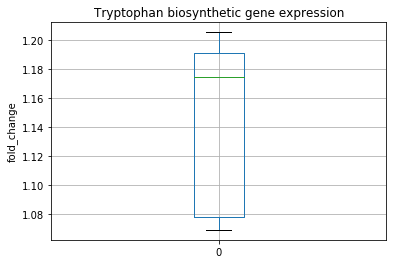

In [18]:
genes = ['trpE','trpD','trpC','trpF','trpB']
fold_change.loc[gene_dictionary.loc[genes]['locus_id']].mean(axis=1).to_frame().boxplot()
plt.ylabel('fold_change')
plt.title('Tryptophan biosynthetic gene expression')

Arginine biosynthesis is downregulated in salt stress.

### Transporter expression

Ethanol transporters are not defined yet in the annotation.

### Up and downregulation

In [19]:
from scipy.stats import ttest_ind,t
alpha = 0.05
decision_df = pd.DataFrame(index=control_data.index,columns=['reg'])
for gene in tqdm(decision_df.index):
    
    a = control_data.loc[gene]
    b = stress_data.loc[gene]
    tval = ttest_ind(b,a).statistic

    pval = t.cdf(tval,df=(len(a)-1)+(len(b)-1))
    if pval > 0.95: # b>a?  
        decision_df.loc[gene]['reg'] = 1
    elif pval < 0.05: # b<a?
        decision_df.loc[gene]['reg'] = -1
    else:
        decision_df.loc[gene]['reg'] = 0

100%|██████████| 5875/5875 [00:15<00:00, 378.49it/s]


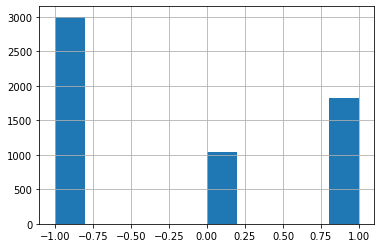

In [20]:
decision_df['reg'].hist()

## M simulations

In [9]:
new_glucose_uptake = bsub.solution.x_dict['EX_glc__D_e']*0.5
base_mu = bsub.solution.f

Bacillus subtilis cannot grow in ethanol only

In [10]:
bsub.reactions.get_by_id('EX_glc__D_e').lower_bound = 0
bsub.reactions.get_by_id('EX_etoh_e').lower_bound = -1
bsub.reactions.ETOHt3.lower_bound = -999999.0 # This transporter is reversible in E. coli
bsub.optimize()

<Solution 0.00 at 0x7efd2da93ba8>

But it can use ethanol as carbon source while using glucose as energy

In [11]:
# Adjust glucose uptake
bsub.reactions.get_by_id('EX_glc__D_e').lower_bound = new_glucose_uptake
flux_dict = dict()
# Ethanol uptake rates and simulation
etoh_rates = -np.arange(0,5,0.1)
for rate in etoh_rates:
    bsub.reactions.get_by_id('EX_etoh_e').lower_bound = rate
    solution = bsub.optimize()
    flux_dict[rate] = solution.x_dict
flux_responses = pd.DataFrame.from_dict(flux_dict)

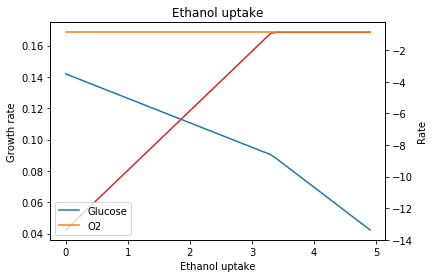

In [12]:
fig,ax1 = plt.subplots()
plt.title('Ethanol uptake')

ax1.plot(-flux_responses.loc['EX_etoh_e'],flux_responses.loc['BIOMASS_BS_10'],
            label = 'growth',color='tab:red')
ax1.set_xlabel('Ethanol uptake')
ax1.set_ylabel('Growth rate')

ax2 = ax1.twinx()
ax2.plot(-flux_responses.loc['EX_etoh_e'],flux_responses.loc['EX_o2_e'],
            label = 'Glucose')
ax2.plot(-flux_responses.loc['EX_etoh_e'],flux_responses.loc['EX_glc__D_e'],
            label = 'O2')
ax2.set_ylabel('Rate')

ax2.legend()

Tryptophan production increases, but it could be an artifact of growth rate

Text(0, 0.5, 'Tryptophan production')

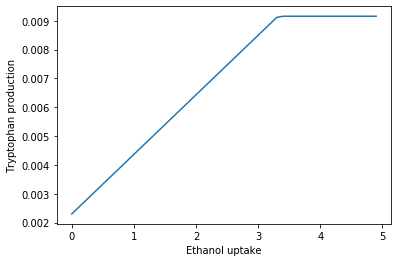

In [13]:
trp_prod = 'TRPS1'
plt.plot(-flux_responses.loc['EX_etoh_e'],flux_responses.loc[trp_prod])
plt.xlabel('Ethanol uptake')
plt.ylabel('Tryptophan production')

Fix growth rate and calculate by minimization of glucose uptake

In [14]:
# Adjust glucose uptake and fix mu to correct the artifact

bsub.reactions.get_by_id('EX_glc__D_e').lower_bound = -10
bsub.reactions.get_by_id('BIOMASS_BS_10').lower_bound = base_mu
bsub.reactions.get_by_id('BIOMASS_BS_10').upper_bound = base_mu

bsub.objective = 'EX_glc__D_e'
bsub.reactions.get_by_id('EX_glc__D_e').objective_coefficient = -1.

# Ethanol uptake rates and simulation
etoh_rates = -np.arange(0,5,0.1)
flux_responses = dict()
for rate in etoh_rates:
    bsub.reactions.get_by_id('EX_etoh_e').lower_bound = rate
    bsub.reactions.get_by_id('EX_etoh_e').upper_bound = rate
    solution = bsub.optimize()
    flux_dict[rate] = solution.x_dict
flux_responses = pd.DataFrame.from_dict(flux_dict)

M-model does not reproduce an increase in Tryptophan production as a result of ethanol processing.

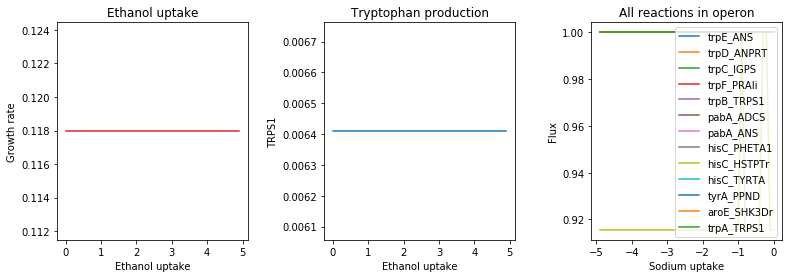

In [15]:
trp_prod = 'TRPS1'

plt.figure(figsize=(13,4))
plt.subplot(1,3,1)

plt.title('Ethanol uptake')
plt.plot(-flux_responses.loc['EX_etoh_e'],flux_responses.loc['BIOMASS_BS_10'],
            label = 'growth',color='tab:red')
plt.xlabel('Ethanol uptake')
plt.ylabel('Growth rate')

plt.subplot(1,3,2)
plt.plot(-flux_responses.loc['EX_etoh_e'],flux_responses.loc[trp_prod])
plt.xlabel('Ethanol uptake')
plt.ylabel('TRPS1')
plt.title('Tryptophan production')

plt.subplot(1,3,3)
gene_dictionary = pd.read_csv('gene_name_dictionary.csv',index_col=1)
genes = ['trpE','trpD','trpC','trpF','trpB','pabA','hisC','tyrA','aroE','trpA']
for idx,gene in enumerate(gene_dictionary.loc[genes]['locus_id'].values):
    rxns = bsub.genes.get_by_id(gene).reactions
    for rxn in rxns:
        flux_profile = abs(flux_responses.loc[rxn.id].values)
        flux_profile /= max(flux_profile)
        plt.plot(etoh_rates,flux_profile,label=genes[idx]+'_'+rxn.id)
plt.title('All reactions in operon')
plt.xlabel('Sodium uptake')
plt.ylabel('Flux')
plt.legend()

plt.subplots_adjust(wspace=0.4)

M-model does not capture changes in tryptophan synthesis

## ME-model simulations of ethanol uptake

In [16]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [17]:
#new_mu = 0.9*me.solution.f
new_mu = False
me.reactions.biomass_dilution.upper_bound = me.solution.f*0.9

In [18]:
# Ethanol can be imported through diffusion
osm_rxn = cobrame.MEReaction('ETOHtex')
me.add_reaction(osm_rxn)

osm_rxn.add_metabolites({'etoh_e':-1,'etoh_c':1})
osm_rxn.lower_bound=0
osm_rxn.upper_bound=1000
print(osm_rxn.id,osm_rxn.lower_bound,osm_rxn.upper_bound,osm_rxn.reaction)   

ETOHtex 0 1000 etoh_e <=> etoh_c


In [19]:
def single_flux_response(me,rate,mu_fix=False):
    me.reactions.get_by_id('EX_etoh_e').lower_bound = rate
    me.reactions.get_by_id('EX_etoh_e').upper_bound = rate
    solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=mu_fix)
    return rate, me.solution.x_dict

In [20]:
etoh_rates = -np.arange(0,4,0.5)
flux_dict = dict()
print('Rates to use: {}'.format(etoh_rates))

import multiprocessing as mp
NP = min([len(etoh_rates),10])
print('Calculating with {} cores'.format(NP))
pool = mp.Pool(NP)
def collect_result(result):
    flux_dict[result[0]] = result[1]
for rate in etoh_rates:
    pool.apply_async(single_flux_response, args=(me,rate,new_mu), callback=collect_result)
pool.close()
pool.join()
flux_responses_me = pd.DataFrame.from_dict(flux_dict)
flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
flux_responses_me.head()

Rates to use: [-0.  -0.5 -1.  -1.5 -2.  -2.5 -3.  -3.5]
Calculating with 8 cores


,-3.5,-3.0,-2.5,-2.0,-1.5,-1.0,-0.5,-0.0
biomass_dilution,0.091549,0.091549,0.091549,0.091549,0.091549,0.091549,0.091549,0.091549
protein_biomass_to_biomass,0.024005,0.023888,0.023771,0.023654,0.023535,0.023416,0.023296,0.024280
mRNA_biomass_to_biomass,0.000084,0.000084,0.000083,0.000083,0.000083,0.000082,0.000082,0.000085
tRNA_biomass_to_biomass,0.000497,0.000495,0.000493,0.000491,0.000488,0.000486,0.000484,0.000513
rRNA_biomass_to_biomass,0.003676,0.003660,0.003645,0.003629,0.003613,0.003597,0.003581,0.003707


In [21]:
# Save results
flux_responses_me.to_csv('ethanol_flux_responses.csv',index_label='rxn_id')

In [5]:
gene_dictionary = pd.read_csv('gene_name_dictionary.csv',index_col=1)
flux_responses_me = pd.read_csv('ethanol_flux_responses.csv',index_col=0)

Text(0.5, 0, 'Ethanol uptake')

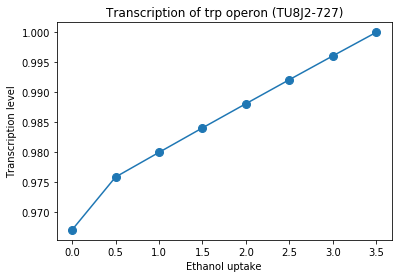

In [6]:
# Visualize transcription profiles

# trp operon is TU8J2-727
expression = flux_responses_me.loc['transcription_TU8J2_727_from_BSU25200-MONOMER']
plt.plot(-flux_responses_me.loc['EX_etoh_e'],
         expression/max(expression),
         marker = 'o',markersize=8)
plt.title('Transcription of trp operon (TU8J2-727)')
plt.ylabel('Transcription level')
plt.xlabel('Ethanol uptake')

Tryptophan production appears to increase with ethanol uptake.

Text(0.5, 1.0, 'promoter')

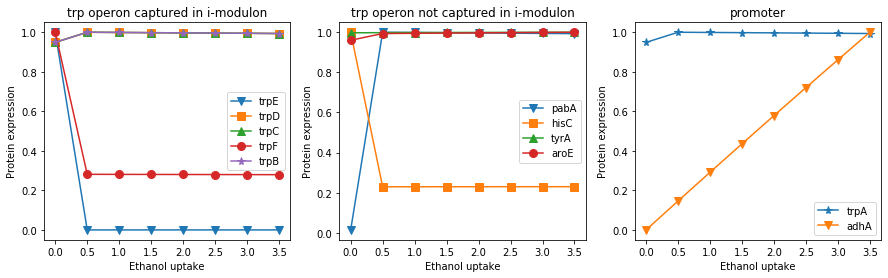

In [7]:
# Visualize protein expression profiles
plt.figure(figsize=(15,4))
import itertools
marker = itertools.cycle(('v', 's', '^', 'o', '*')) 

plt.subplot(1,3,1)

genes = ['trpE','trpD','trpC','trpF','trpB']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_etoh_e'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Ethanol uptake')
plt.ylabel('Protein expression')
plt.title('trp operon captured in i-modulon')

plt.subplot(1,3,2)
genes = ['pabA','hisC','tyrA','aroE']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_etoh_e'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Ethanol uptake')
plt.ylabel('Protein expression')
plt.title('trp operon not captured in i-modulon')

plt.subplot(1,3,3)
genes = ['trpA','adhA']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_etoh_e'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Ethanol uptake')
plt.ylabel('Protein expression')
plt.title('promoter')


Text(0.5, 1.0, 'promoter')

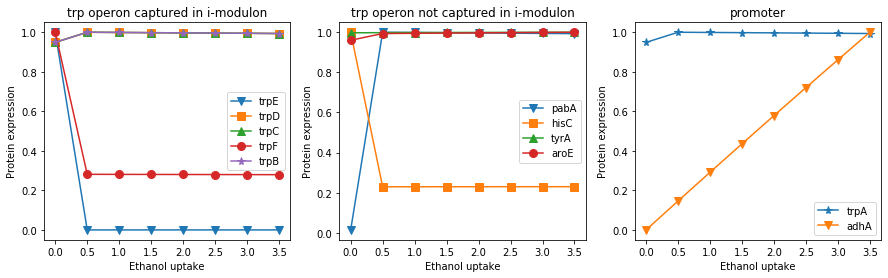

In [8]:
# Normalized by growth rate (yield)
plt.figure(figsize=(15,4))
import itertools
marker = itertools.cycle(('v', 's', '^', 'o', '*')) 

plt.subplot(1,3,1)

genes = ['trpE','trpD','trpC','trpF','trpB']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]/flux_responses_me.loc['biomass_dilution']
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_etoh_e'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Ethanol uptake')
plt.ylabel('Protein expression')
plt.title('trp operon captured in i-modulon')

plt.subplot(1,3,2)
genes = ['pabA','hisC','tyrA','aroE']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]/flux_responses_me.loc['biomass_dilution']
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_etoh_e'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Ethanol uptake')
plt.ylabel('Protein expression')
plt.title('trp operon not captured in i-modulon')

plt.subplot(1,3,3)
genes = ['trpA','adhA']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]/flux_responses_me.loc['biomass_dilution']
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_etoh_e'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Ethanol uptake')
plt.ylabel('Protein expression')
plt.title('promoter')


There is a clear trend of upregulation of tryptophan synthesis being captured by the model.

Notes:
* Ethanol diffuses through the membrane (passive transport).


In [9]:
df = flux_responses_me.loc[flux_responses_me.index.str.contains('EX_')]

In [10]:
df2=df[(abs(df).select_dtypes(include=['number']) > 1e-15).any(1)]
df2 = df2.loc[df2.index.str.contains('_e')]
df2

,-3.5,-3.0,-2.5,-2.0,-1.5,-1.0,-0.5,-0.0
rxn_id,,,,,,,,
EX_ac_e,3.514271e+00,3.014198e+00,2.514124e+00,2.014049e+00,1.513975e+00,1.013900e+00,5.138241e-01,0.000000e+00
EX_acac_e,8.562062e-01,7.282849e-01,6.004338e-01,4.726402e-01,3.445632e-01,2.168490e-01,8.883136e-02,0.000000e+00
EX_co2_e,3.061924e+00,3.575531e+00,4.089194e+00,4.602921e+00,5.116858e+00,5.630728e+00,6.144820e+00,6.525310e+00
EX_cobalt2_e,-5.370200e-08,-5.365061e-08,-5.359675e-08,-5.354038e-08,-5.348164e-08,-5.342012e-08,-5.335616e-08,-5.155581e-08
EX_etoh_e,-3.500000e+00,-3.000000e+00,-2.500000e+00,-2.000000e+00,-1.500000e+00,-1.000000e+00,-5.000000e-01,-0.000000e+00
EX_glc__D_e,-1.699898e+00,-1.699855e+00,-1.699867e+00,-1.699925e+00,-1.699827e+00,-1.699958e+00,-1.699921e+00,-1.699999e+00
EX_h2o_e,9.396981e+00,9.279604e+00,9.162336e+00,9.045169e+00,8.927917e+00,8.810936e+00,8.693860e+00,8.502137e+00
EX_h_e,4.965905e+00,4.336609e+00,3.707372e+00,3.078182e+00,2.448700e+00,1.819568e+00,1.190124e+00,6.006129e-01
EX_k_e,-2.551703e-07,-2.567668e-07,-2.583848e-07,-2.600237e-07,-2.616619e-07,-2.633413e-07,-2.650189e-07,-2.513293e-07


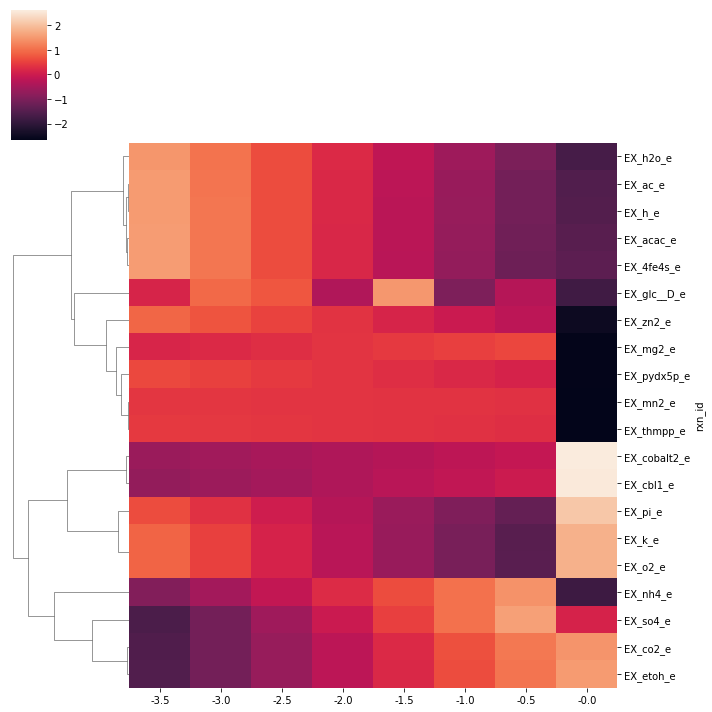

In [11]:
import seaborn as sns
from scipy import stats
a = pd.DataFrame(data=stats.zscore(df2,axis=1),
                 index=df2.index,columns=df2.columns)
sns.clustermap(a,col_cluster = False)

## Accuracy of prediction of transcription response

In [12]:
transcription_response = flux_responses_me.loc[flux_responses_me.index.str.contains('translation')]
all_genes = [gene.split('_')[1] for gene in transcription_response.index]
transcription_df = pd.DataFrame(data=transcription_response.values,index=all_genes,columns=transcription_response.columns)
# Only expressed genes
transcription_df = transcription_df[transcription_df.any(axis=1)]

In [13]:
transcription_df = transcription_df.div(flux_responses_me.loc['biomass_dilution'],axis='columns')

In [15]:
transcription_df

,-3.5,-3.0,-2.5,-2.0,-1.5,-1.0,-0.5,-0.0
BSU00090,2.042631e-07,2.051746e-07,2.060940e-07,2.070212e-07,2.079542e-07,2.088972e-07,2.098459e-07,1.994975e-07
BSU00130,9.713724e-08,9.686203e-08,9.657935e-08,9.628909e-08,9.599125e-08,9.568539e-08,9.537170e-08,9.663331e-08
BSU00140,1.474092e-07,1.485921e-07,1.497885e-07,1.509986e-07,1.522201e-07,1.534577e-07,1.547069e-07,0.000000e+00
BSU00150,3.701856e-08,3.731563e-08,3.761609e-08,3.791997e-08,3.822673e-08,3.853752e-08,3.885124e-08,3.631025e-08
BSU00180,1.407703e-09,1.416381e-09,1.425146e-09,1.433997e-09,1.442919e-09,1.451944e-09,1.461041e-09,1.385799e-09
...,...,...,...,...,...,...,...,...
BSU40890,2.746504e-05,2.734968e-05,2.723321e-05,2.711561e-05,2.699708e-05,2.687723e-05,2.675643e-05,2.764114e-05
BSU40910,2.746504e-05,2.734968e-05,2.723321e-05,2.711561e-05,2.699708e-05,2.687723e-05,2.675643e-05,2.764114e-05
BSU41050,2.648089e-12,2.638994e-12,2.629751e-12,2.620356e-12,2.610818e-12,2.601113e-12,2.591261e-12,2.607018e-12
BSU41060,2.746504e-05,2.734968e-05,2.723321e-05,2.711561e-05,2.699708e-05,2.687723e-05,2.675643e-05,2.764114e-05


What should be the threshold to identify up or downregulation in the model?

In [21]:
thresholds = np.arange(0,0.05,0.001)
accuracies = pd.DataFrame(index=thresholds,columns=['TPR','FNR','FDR'])
for threshold in thresholds:

    predicted_fold_change = ((transcription_df['-3.5']-transcription_df['-0.0'])/transcription_df['-0.0'])

    upregulated_genes = predicted_fold_change[predicted_fold_change>threshold]
    downregulated_genes = predicted_fold_change[predicted_fold_change<-threshold]
    rest_genes = predicted_fold_change[abs(predicted_fold_change)<=threshold]

    predicted_decision = pd.DataFrame(data=np.zeros(len(transcription_df.index)),index=transcription_df.index,columns=['reg'])
    predicted_decision.loc[upregulated_genes.index]= 1
    predicted_decision.loc[downregulated_genes.index] = -1

    decision_results = predicted_decision.join(decision_df,lsuffix='_me',rsuffix='_rna')
    
    
    # Metrics
    P = decision_results[decision_results['reg_rna'] != 0].index
    F = decision_results[decision_results['reg_rna'] == 0].index
    pP = decision_results[decision_results['reg_me'] != 0].index
    pF = decision_results[decision_results['reg_me'] == 0].index

    TP = len(set(P)&set(pP))
    FP = len(pP)-TP
    TN = len(set(F)&set(pF))
    FN = len(pF)-TN

    TPR = TP/(TP+FN)
    FNR = TN/(TN+FP)

    prec = TP/(TP+FP)
    FDR = 1-prec
    
    accuracies.loc[threshold]['TPR'] = TPR
    accuracies.loc[threshold]['FNR'] = FNR
    accuracies.loc[threshold]['FDR'] = FDR

    correct = sum(decision_results['reg_me'] == decision_results['reg_rna'])
    incorrect = len(decision_results.index)-correct

    accuracy = correct/len(decision_results.index)

Text(0, 0.5, 'Metric')

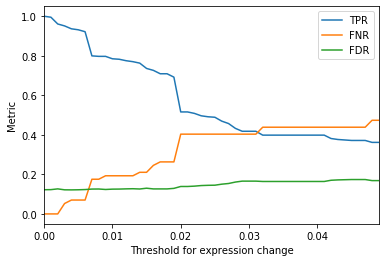

In [22]:
accuracies.plot()
plt.xlabel('Threshold for expression change')
plt.ylabel('Metric')

Seems like the model is able to capture regulation with small changes. Threshold of 0 is the best for accuracy.

In [23]:
threshold = 0.
predicted_fold_change = ((transcription_df['-3.5']-transcription_df['-0.0'])/transcription_df['-0.0'])

upregulated_genes = predicted_fold_change[predicted_fold_change>threshold]
downregulated_genes = predicted_fold_change[predicted_fold_change<-threshold]
rest_genes = predicted_fold_change[abs(predicted_fold_change)<=threshold]

predicted_decision = pd.DataFrame(data=np.zeros(len(transcription_df.index)),index=transcription_df.index,columns=['reg'])
predicted_decision.loc[upregulated_genes.index]= 1
predicted_decision.loc[downregulated_genes.index] = -1

decision_results = predicted_decision.join(decision_df,lsuffix='_me',rsuffix='_rna')
decision_results

correct = sum(decision_results['reg_me'] == decision_results['reg_rna'])
incorrect = len(decision_results.index)-correct

accuracy = correct/len(decision_results.index)

Text(0.5, 1.0, 'Regulation of active genes in the model')

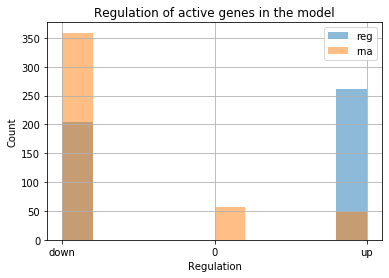

In [24]:
decision_results['reg_me'].hist(alpha=0.5,label='reg')
decision_results['reg_rna'].hist(alpha=0.5,label='rna')

plt.legend()
plt.xlabel('Regulation')
plt.ylabel('Count')
plt.xticks([-1,0,1], ['down',0,'up'])
plt.title('Regulation of active genes in the model')

In [1]:
decision_results

NameError: name 'decision_results' is not defined